# Table of contents
1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
    1. [Data Exploration](#Data-Exploration)
        1. [Class Distribution](#Class-Distribution)
        2. [Size Distribution](#Size-Distribution)
    2. [Data Preprocessing](#Data-Preprocessing)
    3. [Data Augmentation](#Data-Augmentation)
3. [Prediction Model](#Prediction-Model)
4. [Conclusion](#Conclusion)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Introduction <a name="Introduction"></a>

The goal of this challenge is to provide solid approaches to plankton image classification. The notebook is structured in such a way as to explore different tasks, including but not limited to data preparation and model selection.

In the first part, we will work directly with provided images after applying some preprocessing tasks. And then, we will work with the extracted features provided in the features_native file.

# Image Data Preparation <a name="Data-Preparation"></a>

The data set we will be using is composed of ~240K gray scale plankton images that were acquired in the bay of Villefranche and manually engineered features that were computed on each imaged object.

## Data Exploration <a name="Data-Exploration"></a>

First, let's import the data set, have a look at the different available labels and the distribution of images among these classes.

This step is important in order to check wether our data set is imbalanced or not, and then choose the best evaluation metrics, e.g. if a data set is highly imbalanced, evaluating using the confusion matrix is more adapted than an overall accuracy.

In [0]:
import utils
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
img_files = utils.extract_zip_to_memory("/content/drive/My Drive/flowcam/imgs.zip")
np_ids, np_data = zip(*sorted(img_files.items()))
del img_files
np_ids, np_data = list(map(lambda s: int(''.join(filter(str.isdigit, s))), np_ids)), list(map(lambda img: np.array(Image.open(img)), np_data))
del np_ids

Since, we are dealing with a quiet big dataset of images, every time we will try to manage the memory by deleting unused variables.

In [0]:
meta_df = pd.read_csv("/content/drive/My Drive/flowcam/meta.csv")
sorted_level2 = meta_df.groupby('level2').size().sort_values(ascending=False)
sorted_level2.head()

level2
detritus               138439
feces                   26936
Neoceratium             14014
nauplii (Crustacea)      9293
badfocus (artefact)      7848
dtype: int64

### Class Distribution <a name="Class-Distribution"></a>

The next plot shows how many images are available for each class in a descending order.

Note: A linear scale is used between $0$ and $100$ occurences in order to clearly visualize classes with few occurences. And a log scale is used for occurences above $100$ since values can reach $10^5$ for the detritus class.

In [0]:
fog, ax = plt.subplots(figsize=(16, 8))
y_thresh = 1e2
ax.set_yscale('symlog', linthreshy=y_thresh)
ax.hlines(y=y_thresh, xmin=0, xmax=39, linestyles='dashed')
ax.tick_params(axis='x', labelrotation=90)
sns.barplot(x=sorted_level2.index, y=sorted_level2.values, ax=ax)

We can clearly see that we have an imbalanced data set. Working with such a distrubution will have a negative impact classifying images from under represented classes such as Bacteriastrum ($12$ samples), Xystonellidae ($37$ samples), etc. because the model won't be able to lean much about those classes.

One solution for this problem is to use data augmentation. This approach will be discussed later.

### Size Distribution <a name="Size-Distribution"></a>

Now, we will focus on shapes of images. This is an important feature since we are working with an image data set because it will have a direct impact on the training process, e.g, performance and training time.

Let's start by randomly displaying $30$ images picked from the data set.

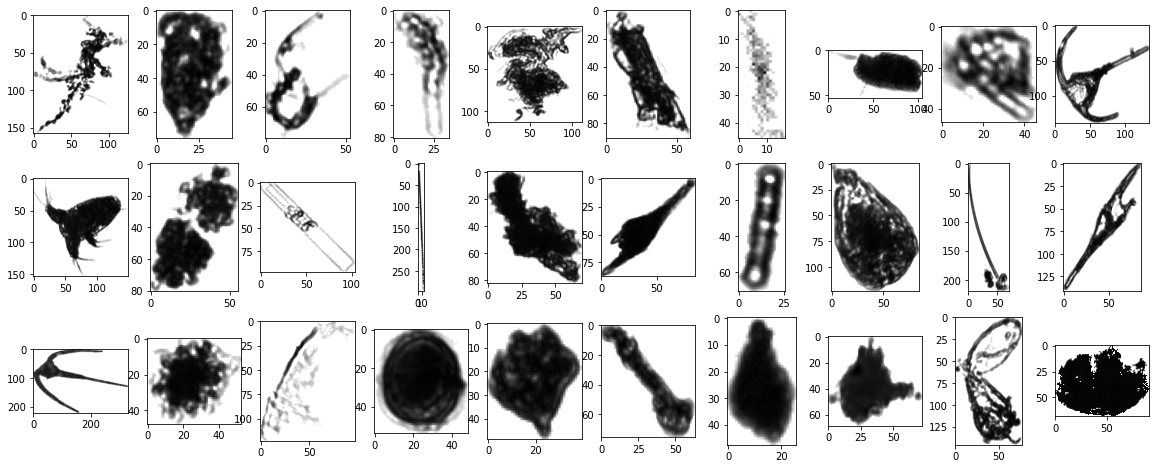

In [0]:
utils.plot(data=np_data, seed=5)

We can see that the images have different shapes. We are going to have a closer look on the distribusion of images' dimesions.

In [0]:
widths, heights = zip(*map(lambda x:x.shape, np_data))

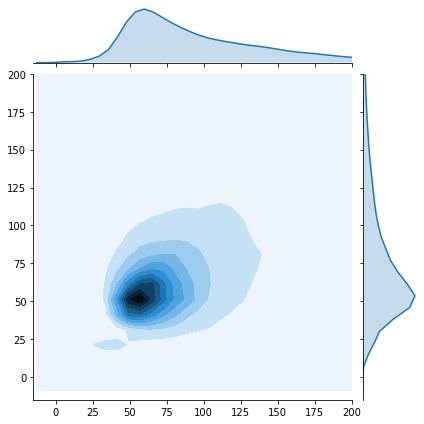

In [0]:
sns.kdeplot(list(widths), label='width', shade=True)
sns.kdeplot(list(heights), label='heights', shade=True)

g2 = sns.jointplot(x=widths, 
                    y=heights, 
                    kind="kde", 
                    xlim=(-15,200),
                    ylim=(-15,200))

In [0]:
del widths
del heights

The KDE plot is used to have a global view on the distribution of the shapes. We can see that the images have very different shapes that vary from few pixels up to about $1000$ pixels. 

The joint plot was a good way to have a closer look on the distribusion of images' dimesions that are between $0$ and $200$ pixels. That helps us to choose the resizing value to be used.

We decided to rescale all images to 64x64x1 pixels for three main reasons:
* We will be using a convolutional neural network so all input samples should have the same size.
* As we can see in the joint plot, the shape distribution is concentrated around this value so we don't have much processing to do.
* This value is not too small so we keep important information, and not too big so training process is much faster.

Note: Resizing the images is based on a a bicubic interpolation over 4x4 pixel neighborhood method already implemented in OpenCV.

## Data Preprocessing <a name="Data-Preprocessing"></a>

Now, let's apply the reshaping function to all the images available in our data set. Then, we will show the same images after reshaping.

In [0]:
np_reshaped_data = list(map(lambda img : utils.reshape(img, 64), np_data))

del np_data

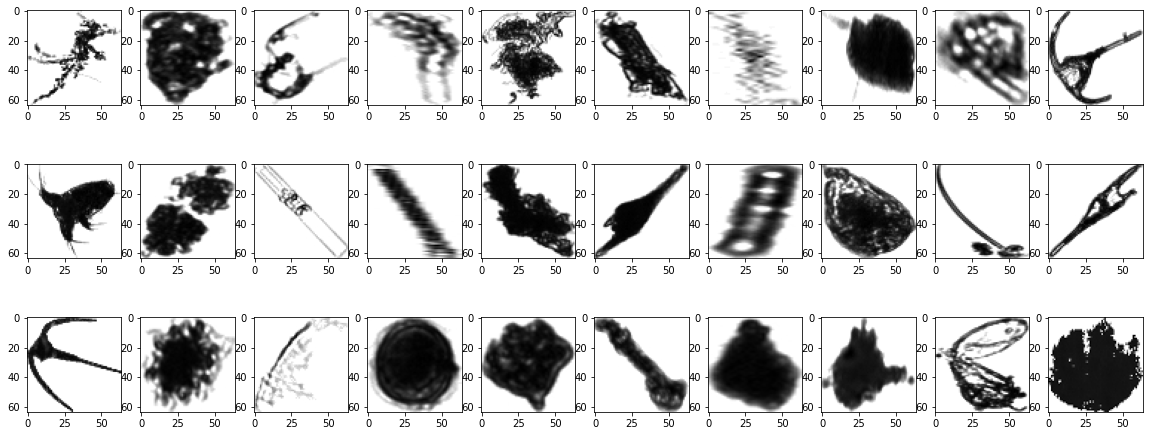

In [0]:
utils.plot(data=np_reshaped_data, seed=5)

In [0]:
np_reshaped_data = np.expand_dims(np.asarray(np_reshaped_data) / 255.0, axis=3)

Finally, we convert data to a NumPy array and scale all pixel intensities to the range [0, 1]. This will help speeding up gradient convergence during the training step.

A neural network cannot operate on label data directly. It requires all input variables and output variables to be numeric. That's why we perform integer encoding for the data labels which transforms categorical data into numerical fields.

In [0]:
labelencoder = LabelEncoder()
meta_df["level2_label"] = labelencoder.fit_transform(meta_df["level2"].astype(str))
#np_y = meta_df.sort_values(by=['objid'])[['objid', 'level2_label']].astype(int).values[:,1]
meta_df=meta_df.sort_values('objid')
cat_targets = pd.factorize(meta_df['level2'])[0]+1 ## We want targets  to start from 0
hot_targets = pd.get_dummies(cat_targets)
np_y=hot_targets

In [0]:
print("Input shape:", np_reshaped_data.shape)
print("Target shape:", np_y.shape)

Input shape: (243610, 64, 64, 1)
Target shape: (243610, 40)


## Data Augmentation <a name="Data-Augmentation"></a>

One of the solutions to solve the problem of imblanced data distribution through the different classes is to perform data augmentation which consists of creating new data samples from the original ones by applying random perturbations to increase the size of the data set. Various transformation can be used such as rotation, translation, rescaling, flipping, etc.

We are going to use on-the-fly data augmentation using ImageDataGenerator class provided by Keras. That means this augmentation will be done at the training time.

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.optimizers.novograd import NovoGrad
from tensorflow.nn import leaky_relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , Dense,MaxPooling2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from sklearn.utils.class_weight import compute_class_weight

In [0]:
from skimage.morphology import binary_erosion,binary_opening
from skimage.filters import threshold_otsu

def threshold(img):
  thresh = threshold_otsu(img)
  binary = img > thresh
  return binary
  
def close(img):
  return binary_opening(img, np.ones((4,4)))
def pre_proc(img):
  img_grey=img[:,:,0]
  imthr=threshold(img_grey)
  imclosed=close(imthr)
  return np.stack((img_grey,imthr,imclosed),axis=2)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
aug = ImageDataGenerator(
	rescale=1./255,
  data_format="channels_last",
	#preprocessing_function=pre_proc,
	validation_split=0.2)

In [0]:
LeNet = Sequential([
    Conv2D(6, (2, 2), activation='relu', input_shape=(64,64, 3)),
    MaxPooling2D(),
    Conv2D(16, (2, 2),activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (2, 2),activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(250, activation='relu'),
    Dense(100, activation='relu'),
    Dense(40,activation='softmax')
])


opt=tf.keras.optimizers.Adam()

LeNet.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=40,average='macro')])

#LeNet.summary()

In [0]:
aug.fit(np_reshaped_data)
# fits the model on batches with real-time data augmentation:
LeNet.fit_generator(aug.flow(np_reshaped_data, np_y, batch_size=32),
                    steps_per_epoch=len(np_reshaped_data) / 32, epochs=10)


# Numerical Data Preparation

In this part, we will deal with numerical features extracted from images. So a whole set of preprocessing tasks well be discussed in the next few steps.

Let's start by importing our data available in the features_native file, join meta data and features on objid and print an overview of the data set.

In [0]:
meta_df = pd.read_csv("/content/drive/My Drive/flowcam/meta.csv")
features_df = pd.read_csv("/content/drive/My Drive/flowcam/features_native.csv")

labelencoder = LabelEncoder()
meta_df["level2_num"] = labelencoder.fit_transform(meta_df["level2"].astype(str))

meta_df.columns

Index(['objid', 'projid', 'id', 'status', 'latitude', 'longitude', 'objdate',
       'objtime', 'depth_min', 'depth_max', 'unique_name', 'lineage', 'level1',
       'level2', 'level2_num'],
      dtype='object')

In [0]:
data_df = features_df.join(meta_df[["objid", "level2_num"]].set_index('objid'), on='objid').drop(["objid"], axis=1)
data_df.describe()

area  meanimagegrey  ...  skeleton_area     level2_num
count  243610.000000  243610.000000  ...  236756.000000  243610.000000
mean     3954.559123     158.489675  ...      82.210980      27.891490
std      5478.161193      27.586551  ...     129.380889       7.226222
min       188.000000       0.000000  ...       3.232558       0.000000
25%      1646.000000     157.300000  ...      27.357576      30.000000
50%      2435.000000     165.310000  ...      44.311377      30.000000
75%      3953.000000     166.920000  ...      85.337580      30.000000
max    280773.000000     174.550000  ...    5658.000000      39.000000

[8 rows x 65 columns]

## Normalization

Similarly to working with images, normalizing the numerical features is an important step that will help speeding up gradient convergence during the training step.

So at the beginning, let's have a quick look at the distribution of means and std values for different features.

Note: we used a log scale for the y axis because values are scattered on a huge range.

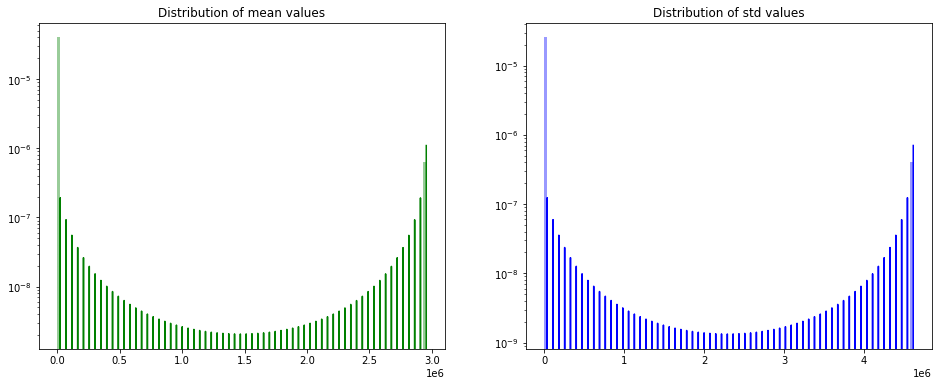

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.distplot(data_df.mean(axis=0), color="green", kde=True, bins=120, ax=ax1)
sns.distplot(data_df.std(axis=0), color="blue", kde=True, bins=120, ax=ax2)

ax1.set_title('Distribution of mean values')
ax2.set_title('Distribution of std values')

ax1.set_yscale('log')
ax2.set_yscale('log')


plt.show()

We can notice that the mean and std values have a wide distribution range (up to 1e6).

We can think about normalizing data by substructing the mean and dividing by the std value of each column. This normalizing step is very important in order to avoid any scaling problem (e.g distances between points won't be dominated by features with high values) and also to speed up the training process (e.g. gradient descent will converge faster).

The new distribution of data values is shown is the next figure.

Note: we use the mean and the std of the training set to normalize in order to avoid introducing a bias in the data.

In [0]:
from sklearn.model_selection import train_test_split
X_train_df, _, _, _ = train_test_split(data_df.drop(['level2_num'], axis=1), data_df['level2_num'], test_size=0.2, random_state=42)

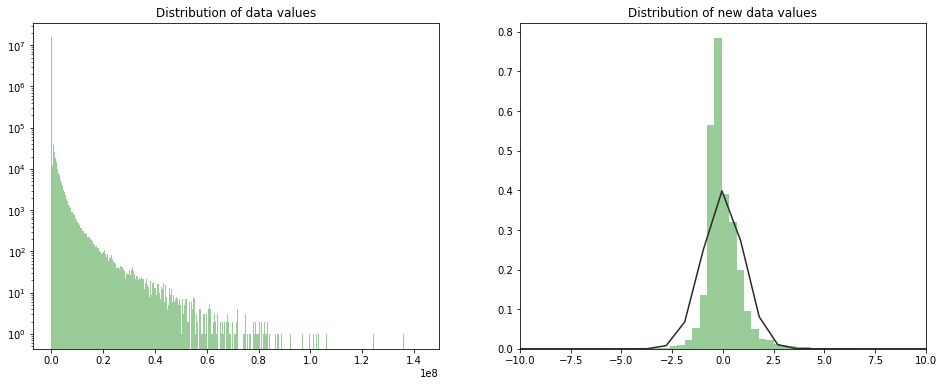

In [0]:
from scipy.stats import norm

features = X_train_df.columns
normalized_df = (X_train_df[features] - X_train_df[features].mean(axis=0)) / X_train_df[features].std(axis=0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.distplot(data_df, kde=False, color="green", bins=500, ax=ax1)
sns.distplot(normalized_df, kde=False, color="green", bins=500, fit=norm, ax=ax2)

ax1.set_title('Distribution of data values')
ax2.set_title('Distribution of new data values')

ax1.set_yscale('log')
#ax2.set_yscale('log')
plt.xlim(-10,10)

plt.show()

## Correlation

As we can see we have so many features describing the data samples. Probably not all of these feature are importatnt to predict our target.

So now, we are going to keep only columns which are relevent to this problem.

So let's have a quick look to the correlation between different features using the correlation matrix.


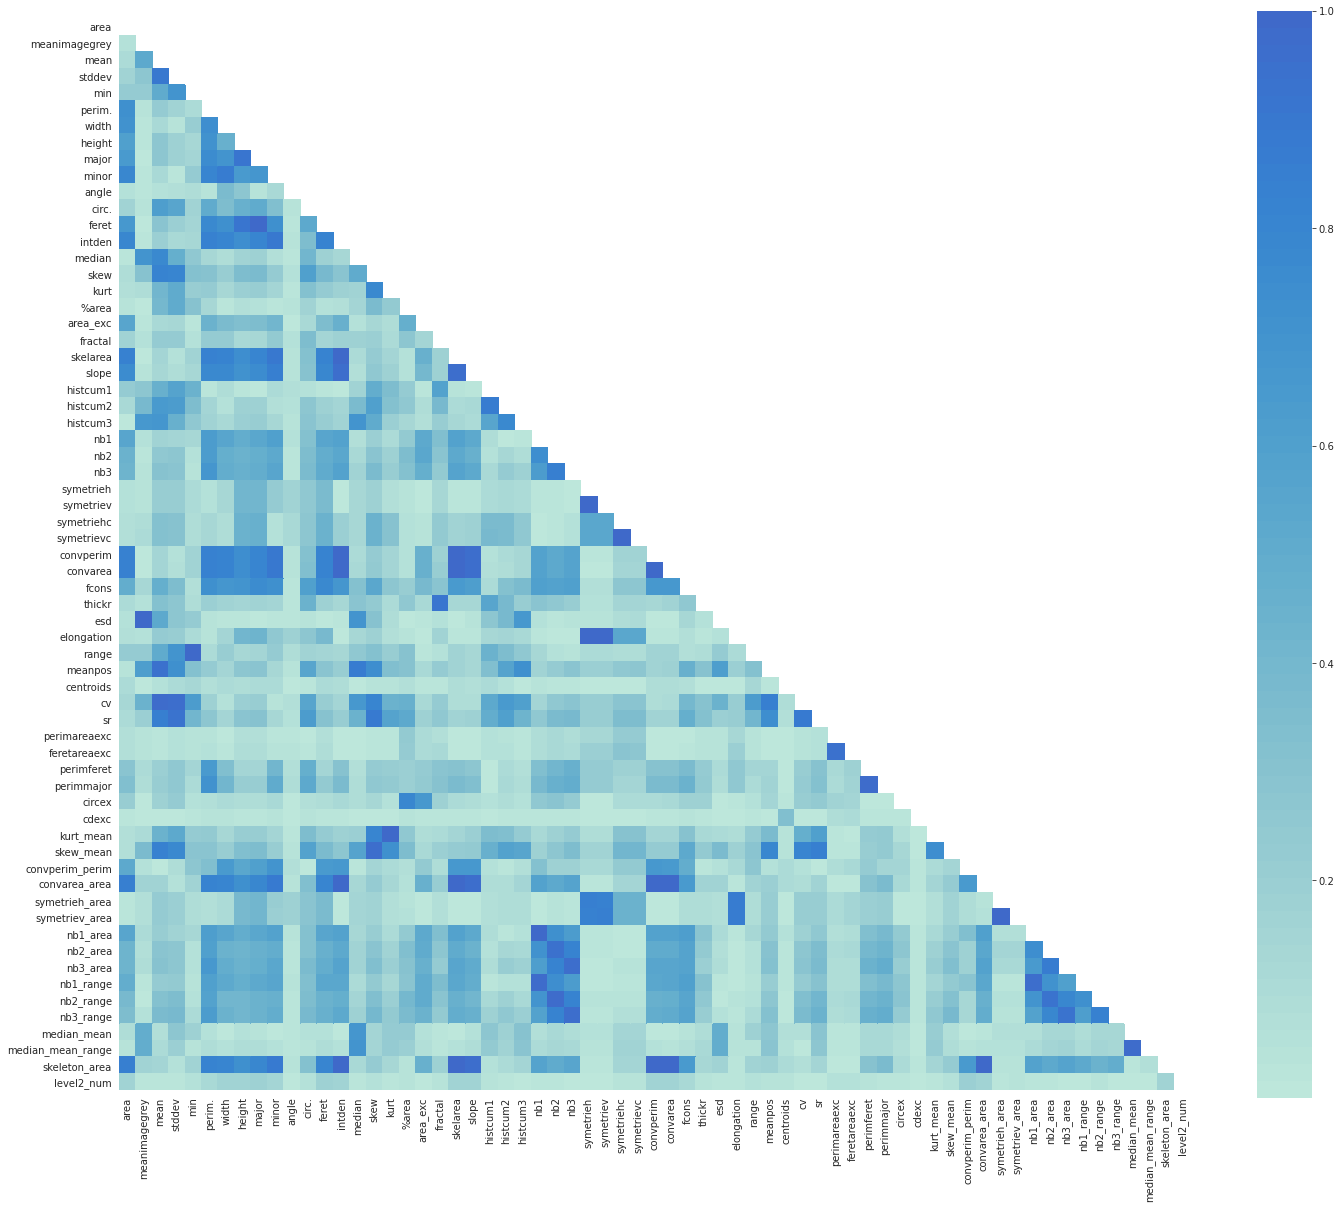

In [0]:
#correlation matrix
normalized_df['level2_num'] = data_df['level2_num']
corrmat = np.abs(normalized_df.corr())
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(24, 20))
    ax = sns.heatmap(corrmat, mask=mask, square=True, center=2)

This heatmap gave us a great overview of our data as well as the relationship between different features.

We notice that there are many darkblue-colored squares: there are obvious correlations such as between nbX, nbX_range and nbX_area.

These columns give almost the same information, so we can get rid of extra ones.


In [0]:
# Select upper triangle of correlation matrix
upper = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

Here is the list of features to drop. As previously discussed it contains 'nb1_area', 'nb2_area', 'nb3_area', 'nb1_range', 'nb2_range' and 'nb3_range' which are correlated with nbX features.

In [0]:
to_drop

['feret',
 'skelarea',
 'slope',
 'symetriev',
 'symetrievc',
 'convperim',
 'convarea',
 'esd',
 'elongation',
 'range',
 'cv',
 'perimmajor',
 'kurt_mean',
 'skew_mean',
 'convarea_area',
 'symetriev_area',
 'nb1_area',
 'nb2_area',
 'nb3_area',
 'nb1_range',
 'nb2_range',
 'nb3_range',
 'median_mean_range',
 'skeleton_area']

In [0]:
new_normalized_df = normalized_df.drop(to_drop, axis=1)

## Missing Data

In [0]:
# Missing Data
total = new_normalized_df.isnull().sum().sort_values(ascending=False)
percent = (new_normalized_df.isnull().sum()/new_normalized_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

Total   Percent
cdexc           27565  0.141440
feretareaexc    27565  0.141440
perimareaexc    27565  0.141440
symetrieh_area   5392  0.027667
level2_num          0  0.000000

We notice that 4 different columns have missing data. Since our data set is quiet big, we can choose to drop all samples that have at least one missing value and that won't affect our results.

In [0]:
new_normalized_df = new_normalized_df.dropna()

## Dataholders

We split our data using the same random_state previously used in order to get the same training and testing set. Then, we use One-Hot Encoder to get numerical labels and finally convert our data to numpy arrays.

Now, our data is ready to be used to train the model!

In [0]:
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(new_normalized_df.drop(['level2_num'], axis=1), new_normalized_df['level2_num'], test_size=0.2, random_state=42)

In [0]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = y_train_df.values.reshape(len(y_train_df.values), 1)
y_train = onehot_encoder.fit_transform(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = y_test_df.values.reshape(len(y_test_df.values), 1)
y_test = onehot_encoder.fit_transform(integer_encoded)

In [0]:
X_train, X_test = X_train_df.values, X_test_df.values
y_train, y_test = y_train_df.values, y_test_df.values
print("Features matrix shape:", X_train.shape)
print("Targets vector shape:", y_train.shape)

Features matrix shape: (129596, 40)
Targets vector shape: (129596,)


# Models

## Model for Images

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.optimizers.novograd import NovoGrad
from tensorflow.nn import leaky_relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , Dense,MaxPooling2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd


meta_df = pd.read_csv("/content/drive/My Drive/plankton_challenge/meta.csv")

cat_targets = pd.factorize(meta_df['level2'])[0]+1 ## We want targets  to start from 0
hot_targets = pd.get_dummies(cat_targets)
hot_targets=hot_targets.set_index(meta_df['objid'].astype(int))

## define constants
IMG_SIZE=(64,64)
NUM_IMG=cat_targets.size
BATCH_SIZE=512
EPOCHS=25


### Data balancing

In the previous section we noticed that the data distribution with respect to classes is heavily skewed. If left unchanged our model would be more biased towards predicting classes with high cardinality.

If we were aiming sollely for accuracy this wouldn't matter as the **top 3 most occuring classes cover 70% of our data** and our model would do great just by predicting these classes.

But our metric is the F1 score which gives **equal importance** to all of the classes. Thus we need to find a way to balance our data during training.

We considerer using some data augmentation techniques  **ONLY** for the classes with low occurences, such as zooming, flipping ... but we couldn't find a time efficient way to do this.


Our workaround consisted of assigning **weights to each class**, such that the model is penalized more for missclassifying low cardinality classes.



In [0]:
weights=compute_class_weight('balanced',np.unique(cat_targets),cat_targets)
class_weights= dict(zip(np.unique(cat_targets),weights))

Our input consist of 64*64 grayscale images.

We will be using **Convolution Neural Networks** to make our predictions.

Usually CNNs work with RGB images wich have 3 different channels.

Inspired by this idea, our input image will have **3 channels as well**

A channel for the normal **grayscale** image, one for the image passed through a **thresholing** filter. And one where we perform the morpholigical operation of **opening.**

Opening should get rid of static around borders along with small artefacts whereas thresholding should make details clearer.

The intuition is that stacking these channels will give our model a clearer view of the object.

In [0]:
from skimage.morphology import binary_erosion,binary_opening
from skimage.filters import threshold_otsu

def threshold(img):
  thresh = threshold_otsu(img)
  binary = img > thresh
  return binary
  
def close(img):
  return binary_opening(img, np.ones((4,4)))
def pre_proc(img):
  img_grey=img[:,:,0]
  imthr=threshold(img_grey)
  imclosed=close(imthr)
  return np.stack((img_grey,imthr,imclosed),axis=2)




Text(0.5, 1.0, 'Opened Image')

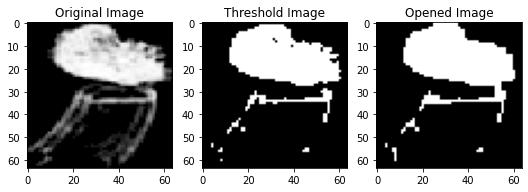

In [0]:
import matplotlib.pyplot as plt
from pylab import cm

Images,targets=next(train_gen)
img=Images[0]
imgrey=img[:,:,0]
imthr=img[:,:,1]
imclosed=img[:,:,2]

f = plt.figure(figsize=(12,3))

sub1 = plt.subplot(1,4,1)
plt.imshow(imgrey, cmap=cm.gray_r)
sub1.set_title("Original Image")

sub2 = plt.subplot(1,4,2)
plt.imshow(imthr, cmap=cm.gray_r)
sub2.set_title("Threshold Image")

sub3 = plt.subplot(1,4,3)
plt.imshow(imclosed, cmap=cm.gray_r)
sub3.set_title("Opened Image")

Our dataset is too large to fit in memory.

To fix this problem we inherit the **DirectoryIterator** class.

This class allows us to fetch data from directory and feed it in real time to the model.

**Note :** We considered using the **flow_from_directory** function from Keras but this function required a specific structure of the training folder. It uses this structure to set the image labels.

To work our way around this we had to set the image attributes manually for each batch yielded by the generator.

We do this by overriding the **get_batches_of_transformed_samples** function.



In [0]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

class ImageWithLabels(DirectoryIterator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.objids = np.array([int(path[12:20]) for path in self.filepaths])
        self.class_mode = None # so that we only get the images back
    def __targets__(self,one_hot):
      self.targets=one_hot.loc[self.objids].reset_index(drop=True).values

    def _get_batches_of_transformed_samples(self, index_array):
        return (super()._get_batches_of_transformed_samples(index_array),
                self.targets[index_array])
    

We use the **ImageDataGenerator** class that allows us to perform data augmentation and preprocessing while reading from directory. And split our data into train and test set.

In [0]:
imagegen =  ImageDataGenerator(
	rescale=1./255,
  data_format="channels_last",
	preprocessing_function=pre_proc,
	validation_split=0.2)

train_gen = ImageWithLabels(directory='./data', image_data_generator=imagegen, target_size=IMG_SIZE,batch_size=BATCH_SIZE,shuffle=True,subset='training')
train_gen.__targets__(hot_targets)


test_gen = ImageWithLabels(directory='./data', image_data_generator=imagegen, target_size=IMG_SIZE,batch_size=BATCH_SIZE,subset='validation')
test_gen.__targets__(hot_targets)


Found 194888 images belonging to 1 classes.
Found 48722 images belonging to 1 classes.


In [0]:
def tGen():
  return train_gen

def tstGen():
  return test_gen

train_ds = tf.data.Dataset.from_generator(
    tGen, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([BATCH_SIZE,64,64,3], [BATCH_SIZE,40])
)

test_ds = tf.data.Dataset.from_generator(
    tstGen, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([BATCH_SIZE,64,64,3], [BATCH_SIZE,40])
)



For our CNN architecture we chose an architecture similar to [LeNET](https://engmrk.com/lenet-5-a-classic-cnn-architecture/). 

With 3 Convd + Maxpool layers and 3 Fully connected layers.


We use google colab with GPU's for training.

Even with a relatively shallow network. Training time is of 4 minutes per epoch. 

**Note:** Colab runtimes stop after approx 1h limiting us to 20 epochs for training.

In [0]:
LeNet = Sequential([
    Conv2D(6, (2, 2), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(),
    Conv2D(16, (2, 2),activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (2, 2),activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(250, activation='relu'),
    Dense(100, activation='relu'),
    Dense(40,activation='softmax')
])


opt=tf.keras.optimizers.Adam()

LeNet.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=40,average='macro')])

#LeNet.summary()

We train our model

In [0]:
import warnings
warnings.filterwarnings("ignore")
train_ds=train_ds.prefetch(tf.data.experimental.AUTOTUNE)
LeNet.fit(train_gen, epochs=1,class_weight=class_weights,steps_per_epoch=190000/BATCH_SIZE)


372/371 [==============================] - 225s 605ms/step - loss: 0.3235 - accuracy: 0.5294 - f1_score: 0.4571


After 30 epochs our model reaches an accuracy of 50% and an F1 score of 30% on test set.

It is worth mentioning that if we choose **not to use use class weights**our model can reach an accuracy of 80% and an F1 score of 25%.

In [0]:
loss,accuracy,F1_score = LeNet.evaluate_generator(test_gen)
print("Accuracy = ",accuracy, 'Loss = ',loss," Score = ",F1_score)

Accuracy =  0.5482328534126282 Loss =  1.5674445629119873  Score =  0.3294264078140259


Having an image classification task at hand. One could re use **pre-trained** models on big datasets such as cifar 10.

Such operation is called transfer learning where we take a pre-trained model ( A VGG 19 in our case) and remove the Fully connected layers on top that serve for classification.

The idea is that in order to perform classifications on datasets as large as Cifar100, VGG19 learns a latent image representation in the level of it's intermediate layers. For example it can learn to find patters such wheels and other geometrical shapes.

**Training** : We freeze the first layers (which consist of convolutions) so that we dont have to retrain the whole model. Then we add some FC layers whose weights we'll be training for our task.

**NOTE :** One epoch requires approx 11 minutes for no major change in accuracy. Training such a model may require a high number of epochs and we didn't have the time to do so.

In [0]:
from tensorflow.keras.applications import VGG19
# Create the base model of VGG19
base_model= VGG19 ( include_top=False, input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3), classes = 40)


base_model.trainable = False

model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(4096,activation='relu'),
  Dense(40, activation='sigmoid')
])


model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=40,average='macro')])

model.fit(train_ds, epochs=EPOCHS,validation_data=test_ds,class_weight=class_weights,steps_per_epoch=190000/BATCH_SIZE,use_multiprocessing=True)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/25
 42/468 [=>............................] - ETA: 11:09 - loss: 3.1625 - accuracy: 0.0043 - f1_score: 0.0154

KeyboardInterrupt: ignored

## Medel for Numerical Data

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

import xgboost as xgb
from sklearn.utils import class_weight

In [0]:
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train))

w_array = np.ones(y_train.shape[0], dtype = 'int')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]


In [0]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", 
                              num_class=40, 
                              random_state=42, 
                              tree_method='gpu_hist', 
                              gpu_id=0)
xgb_model.fit(X_train, y_train, sample_weight=w_array, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, num_class=40, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)

In [0]:
y_pred = xgb_model.predict(X_test)

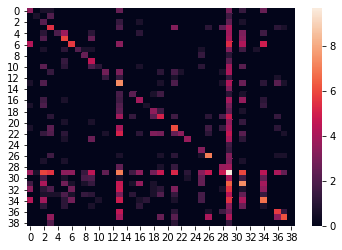

In [0]:
sns.heatmap(np.log(confusion_matrix(y_test, y_pred)+1))

In [0]:
f1_score(y_test, y_pred, average='macro')

0.3323908881400761

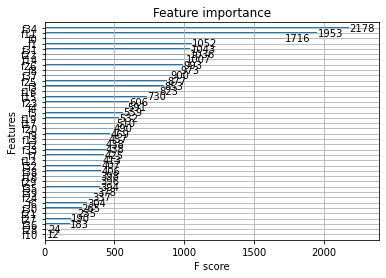

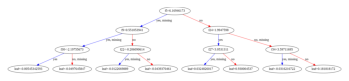

In [0]:
import graphviz

xgb.plot_importance(xgb_model)
xgb.plot_tree(xgb_model)